# Importing Libraries

In [115]:
import os
import fitz  # PyMuPDF for PDF text extraction
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import torch
from transformers import BertTokenizer, BertModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from scipy.stats import chi2_contingency
from torch.optim import AdamW 
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

In [2]:
# pip install PyMuPDF
# pip install transformers

In [3]:
# pip install aequitas

# Loading the dataset & Exploration

In [2]:
# Loading the extracted data csv file
df = pd.read_csv(r"C:\Users\LENOVO\Desktop\resume_kaly\All_resumes\Resumes_data.csv", encoding='latin1')

In [3]:
df.head()

,ID,Resume_str,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",HR
2,33176873,HR DIRECTOR Summary Over 2...,HR
3,27018550,HR SPECIALIST Summary Dedica...,HR
4,17812897,HR MANAGER Skill Highlights ...,HR


In [4]:
df.tail()

,ID,Resume_str,Category
3430,99807073,Computer Skills: Proficient in MS office (Word...,Testing
3431,99807074,Willingness to accept the challenges. Positi...,Testing
3432,99807075,"PERSONAL SKILLS Quick learner, Eagerness to le...",Testing
3433,99807076,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...,Testing
3434,99807077,Skill Set OS Windows XP/7/8/8.1/10 Database MY...,Testing


In [5]:
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3435 entries, 0 to 3434
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          3434 non-null   object
 1   Resume_str  3431 non-null   object
 2   Category    3417 non-null   object
dtypes: object(3)
memory usage: 80.6+ KB
None


In [6]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
ID             1
Resume_str     4
Category      18
dtype: int64


In [7]:
# Drop rows with missing values in 'ID' and 'Resume_str' columns
df = df.dropna(subset=['ID', 'Resume_str'])

In [8]:
print("\nMissing Values:") 
print(df.isnull().sum())


Missing Values:
ID             0
Resume_str     0
Category      14
dtype: int64


In [9]:
print("\nUnique Categories:")
print(df['Category'].unique())


Unique Categories:
['HR' 'DESIGNER' 'INFORMATION-TECHNOLOGY' nan 'TEACHER' 'ADVOCATE'
 'BUSINESS-DEVELOPMENT' 'HEALTHCARE' 'FITNESS' 'AGRICULTURE' 'BPO' 'SALES'
 'CONSULTANT' 'DIGITAL-MEDIA' 'AUTOMOBILE' 'CHEF' 'FINANCE' 'APPAREL'
 'ENGINEERING' 'ACCOUNTANT' 'CONSTRUCTION' 'PUBLIC-RELATIONS' 'BANKING'
 'ARTS' 'AVIATION' 'Data Science' 'Advocate' 'Arts' 'Web Designing'
 'Mechanical Engineer' 'Sales' 'Health and fitness' 'Civil Engineer'
 'Java Developer' 'Business Analyst' 'SAP Developer' 'Automation Testing'
 'Electrical Engineering' 'Operations Manager' 'Python Developer'
 'DevOps Engineer' 'Network Security Engineer' 'PMO' 'Database' 'Hadoop'
 'ETL Developer' 'DotNet Developer' 'Blockchain' 'Testing']


In [10]:
print("\nResumes Count by Category:")
print(df['Category'].value_counts())


Resumes Count by Category:
Category
HR                           153
INFORMATION-TECHNOLOGY       119
BUSINESS-DEVELOPMENT         118
FITNESS                      117
AVIATION                     117
FINANCE                      116
ENGINEERING                  116
CHEF                         116
ACCOUNTANT                   116
SALES                        115
ADVOCATE                     115
CONSULTANT                   115
BANKING                      115
HEALTHCARE                   113
PUBLIC-RELATIONS             109
CONSTRUCTION                 108
DESIGNER                     106
ARTS                         103
TEACHER                      102
APPAREL                       96
DIGITAL-MEDIA                 95
Java Developer                84
Testing                       70
AGRICULTURE                   63
DevOps Engineer               55
Python Developer              48
Web Designing                 45
Hadoop                        42
Mechanical Engineer           40
ETL De

In [11]:
print("\nExample Resume Text:")
print(df['Resume_str'][0])


Example Resume Text:
         HR ADMINISTRATOR/MARKETING ASSOCIATE

HR ADMINISTRATOR       Summary     Dedicated Customer Service Manager with 15+ years of experience in Hospitality and Customer Service Management.   Respected builder and leader of customer-focused teams; strives to instill a shared, enthusiastic commitment to customer service.         Highlights         Focused on customer satisfaction  Team management  Marketing savvy  Conflict resolution techniques     Training and development  Skilled multi-tasker  Client relations specialist           Accomplishments      Missouri DOT Supervisor Training Certification  Certified by IHG in Customer Loyalty and Marketing by Segment   Hilton Worldwide General Manager Training Certification  Accomplished Trainer for cross server hospitality systems such as    Hilton OnQ  ,   Micros    Opera PMS   , Fidelio    OPERA    Reservation System (ORS) ,   Holidex    Completed courses and seminars in customer service, sales strategies, invento

# Text Preprocessing

In [12]:
# Standardizing:Making the resume text is clean and uniform for Making it easy for further steps

def standardize_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    return text.strip().lower()  # Convert to lowercase and trim

In [13]:
# Applying standardization to the 'Resume_str' column
df['Standardized_Resume'] = df['Resume_str'].apply(standardize_text)

print(df[['Resume_str', 'Standardized_Resume']].head())

                                          Resume_str  \
0           HR ADMINISTRATOR/MARKETING ASSOCIATE\...   
1           HR SPECIALIST, US HR OPERATIONS      ...   
2           HR DIRECTOR       Summary      Over 2...   
3           HR SPECIALIST       Summary    Dedica...   
4           HR MANAGER         Skill Highlights  ...   

                                 Standardized_Resume  
0  hr administratormarketing associate hr adminis...  
1  hr specialist us hr operations summary versati...  
2  hr director summary over years experience in r...  
3  hr specialist summary dedicated driven and dyn...  
4  hr manager skill highlights hr skills hr depar...  


In [14]:
# Adding a new column for finding the length of resume text after filling the NaN/NoN_string/Invalid values

df['Text_Length'] = df['Standardized_Resume'].apply(len)

In [15]:
print(df.head())

         ID                                         Resume_str Category  \
0  16852973           HR ADMINISTRATOR/MARKETING ASSOCIATE\...       HR   
1  22323967           HR SPECIALIST, US HR OPERATIONS      ...       HR   
2  33176873           HR DIRECTOR       Summary      Over 2...       HR   
3  27018550           HR SPECIALIST       Summary    Dedica...       HR   
4  17812897           HR MANAGER         Skill Highlights  ...       HR   

                                 Standardized_Resume  Text_Length  
0  hr administratormarketing associate hr adminis...         4767  
1  hr specialist us hr operations summary versati...         4948  
2  hr director summary over years experience in r...         7026  
3  hr specialist summary dedicated driven and dyn...         2545  
4  hr manager skill highlights hr skills hr depar...         8509  


In [16]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
ID                      0
Resume_str              0
Category               14
Standardized_Resume     0
Text_Length             0
dtype: int64


In [17]:
# Missing Category values 
print(df[df['Category'].isnull()])

            ID                                         Resume_str Category  \
329   18067556           MASTER DATA MANAGER           Experie...      NaN   
490   19063156           SENIOR MEMBER SERVICE ADVOCATE       ...      NaN   
491   91051945           BUSINESS ADVOCATE BANKER      Cruz   ...      NaN   
540   18090899           SENIOR ADVISOR AND NATIONAL FUNDRAISI...      NaN   
575   37521676           BUSINESS DEVELOPMENT MANAGER         ...      NaN   
680   28670024             HEALTHCARE PROVIDER         Profess...      NaN   
989   45077654           CLAIMS SUBJECT MATTER EXPERT         ...      NaN   
1080  17704246           SALES ASSOCIATE       Summary     Exp...      NaN   
1360  14663897           CHEF       Credentials     National R...      NaN   
1480  15891494           FINANCE OFFICER       Summary    Prof...      NaN   
1783  13264796           DIRECTOR OF ENGINEERING           Exp...      NaN   
1924  26509539           CONSTRUCTION INSTALLER       Summary ..

In [18]:
print("\nResume Text Length Statistics:")
print(df['Text_Length'].describe())


Resume Text Length Statistics:
count     3431.000000
mean      4813.724279
std       2734.001687
min        118.000000
25%       2767.000000
50%       4859.000000
75%       6106.000000
max      30968.000000
Name: Text_Length, dtype: float64


In [19]:
# Checking for duplicate values...
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


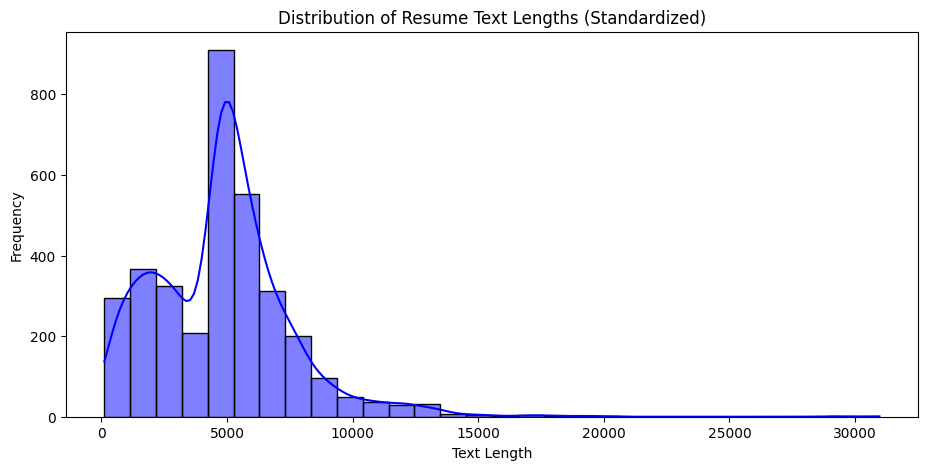

In [22]:
# Visualizing distribution of resume text lengths
plt.figure(figsize=(11, 5))
sns.histplot(df['Text_Length'], kde=True, bins=30, color='blue')
plt.title('Distribution of Resume Text Lengths (Standardized)')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

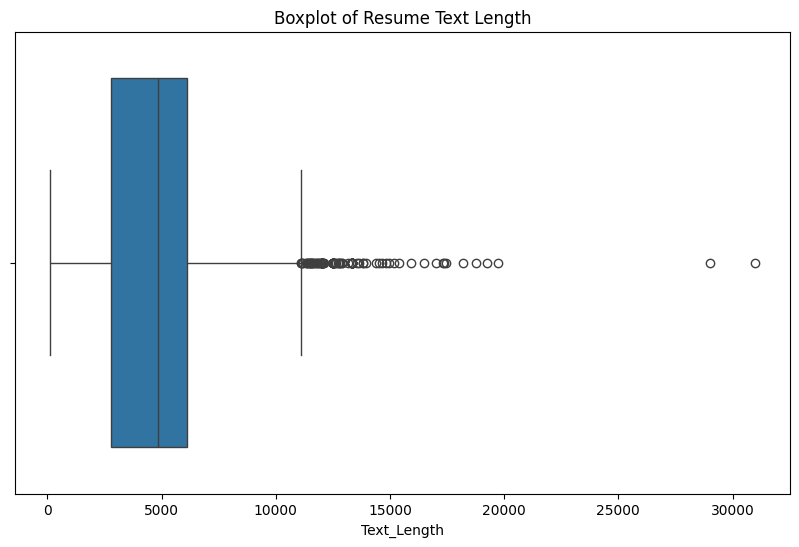

In [23]:
# Visualizing outliers using Boxplot

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Text_Length')
plt.title("Boxplot of Resume Text Length")
plt.show()

In [20]:
# Sorting the DataFrame by Text_Length in descending order and removing top 5 highest outliers..

sorted_df = df.sort_values(by='Text_Length', ascending=False)
top_5_indices = sorted_df.head(5).index

df = df.drop(index=top_5_indices)

In [21]:
df

,ID,Resume_str,Category,Standardized_Resume,Text_Length
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR,hr administratormarketing associate hr adminis...,4767
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",HR,hr specialist us hr operations summary versati...,4948
2,33176873,HR DIRECTOR Summary Over 2...,HR,hr director summary over years experience in r...,7026
3,27018550,HR SPECIALIST Summary Dedica...,HR,hr specialist summary dedicated driven and dyn...,2545
4,17812897,HR MANAGER Skill Highlights ...,HR,hr manager skill highlights hr skills hr depar...,8509
...,...,...,...,...,...
3430,99807073,Computer Skills: Proficient in MS office (Word...,Testing,computer skills proficient in ms office word b...,1876
3431,99807074,Willingness to accept the challenges. Positi...,Testing,willingness to accept the challenges positive ...,2098
3432,99807075,"PERSONAL SKILLS Quick learner, Eagerness to le...",Testing,personal skills quick learner eagerness to lea...,2836
3433,99807076,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...,Testing,computer skills software knowledge mspower poi...,686


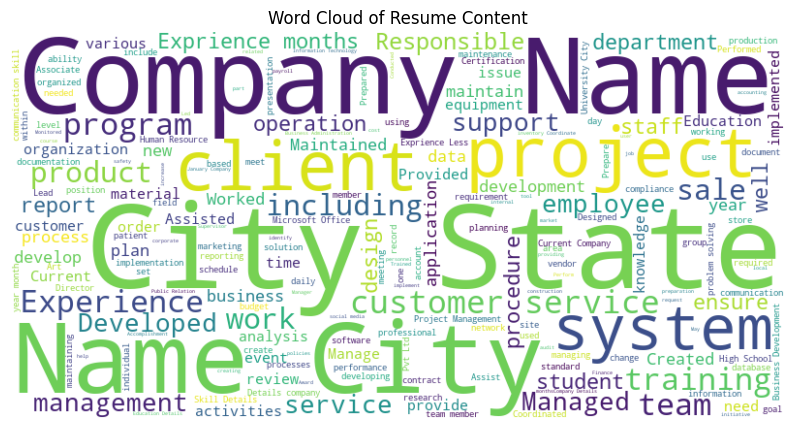

In [26]:
# Word clouds to provide insights into the most frequent words in the resumes...

combined_text = ' '.join(df['Resume_str'].dropna())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Resume Content")
plt.show()

# Feature Extraction using BERT

In [22]:
# Loading pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Setting the model to evaluation mode to eliminate behaving differently while training
model.eval() 

# Moving the model to the appropriate device (CPU/GPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

print(f"Model and tokenizer loaded successfully. Using device: {device}")

Model and tokenizer loaded successfully. Using device: cpu


In [23]:
# Tokenizing and generating embeddings for the entire dataset
def extract_bert_embeddings(text, tokenizer, model, max_len=512):
    inputs = tokenizer(
        text,
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    )
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    # Generating embeddings
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state  # Token-level embeddings
        sentence_embedding = torch.mean(embeddings, dim=1)  # Mean pooling

    return sentence_embedding.cpu().numpy()

In [33]:
# Tokenizing and extracting embeddings for the entire dataset
all_embeddings = []
for resume in df['Resume_str']:
    embedding = extract_bert_embeddings(resume, tokenizer, model)
    all_embeddings.append(embedding)

# Converting embeddings to a NumPy array
df['BERT_Embeddings'] = all_embeddings

# Saving embeddings for future use
np.save("bert_embeddings.npy", np.array(all_embeddings))
print("Embeddings extracted and saved successfully.")

Embeddings extracted and saved successfully.


# Loading Pre-Saved Bert Embeddings from numpy file

In [24]:
bert_embeddings = np.load('bert_embeddings.npy', allow_pickle=True)

# Assigning embeddings back to the DataFrame
df['BERT_Embeddings'] = list(bert_embeddings)

# Predicting Missing categories

In [35]:
# Separating rows with and without categories
train_data = df.dropna(subset=['Category'])  # Rows with known categories
missing_data = df[df['Category'].isnull()]  # Rows with missing categories

In [36]:
# Preparing data for logistic regression
embedding_train = np.vstack(train_data['BERT_Embeddings'])  # Features for training
y_train = train_data['Category']  # Labels for training
embedding_missing = np.vstack(missing_data['BERT_Embeddings'])  # Features for predicting missing categories

In [37]:
# print(embedding_train.head())
print(y_train.head())

0    HR
1    HR
2    HR
3    HR
4    HR
Name: Category, dtype: object


In [38]:
# Training LogisticRegression model
classifier = LogisticRegression(random_state=42, max_iter=1000)
classifier.fit(embedding_train, y_train)

# Predicting missing categories
predicted_categories = classifier.predict(embedding_missing)

In [39]:
# Updating the original dataframe with predicted categories
df.loc[df['Category'].isnull(), 'Category'] = predicted_categories

In [40]:
from sklearn.preprocessing import LabelEncoder

# Encoding 'Category' using LabelEncoder
label_encoder = LabelEncoder()
df['Category'] = label_encoder.fit_transform(df['Category'].astype(str))

# Verifying encoding and ensuring there are no missing values
print("Category Mapping:")
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
print("\nMissing Values After Prediction:")
print(df.isnull().sum())

Category Mapping:
{'ACCOUNTANT': np.int64(0), 'ADVOCATE': np.int64(1), 'AGRICULTURE': np.int64(2), 'APPAREL': np.int64(3), 'ARTS': np.int64(4), 'AUTOMOBILE': np.int64(5), 'AVIATION': np.int64(6), 'Advocate': np.int64(7), 'Arts': np.int64(8), 'Automation Testing': np.int64(9), 'BANKING': np.int64(10), 'BPO': np.int64(11), 'BUSINESS-DEVELOPMENT': np.int64(12), 'Blockchain': np.int64(13), 'Business Analyst': np.int64(14), 'CHEF': np.int64(15), 'CONSTRUCTION': np.int64(16), 'CONSULTANT': np.int64(17), 'Civil Engineer': np.int64(18), 'DESIGNER': np.int64(19), 'DIGITAL-MEDIA': np.int64(20), 'Data Science': np.int64(21), 'Database': np.int64(22), 'DevOps Engineer': np.int64(23), 'DotNet Developer': np.int64(24), 'ENGINEERING': np.int64(25), 'ETL Developer': np.int64(26), 'Electrical Engineering': np.int64(27), 'FINANCE': np.int64(28), 'FITNESS': np.int64(29), 'HEALTHCARE': np.int64(30), 'HR': np.int64(31), 'Hadoop': np.int64(32), 'Health and fitness': np.int64(33), 'INFORMATION-TECHNOLOGY': n

In [41]:
# Encoding 'Category' labels directly as int
df['Category'] = df['Category'].astype('category').cat.codes

In [42]:
# Keeping only rows with valid labels
df = df[df['Category'] >= 0] 

In [43]:
df.to_csv(r"C:\Users\LENOVO\Desktop\resume_kaly\All_resumes\Resumes_data2.csv", index=False)

In [25]:
df = pd.read_csv(r"C:\Users\LENOVO\Desktop\resume_kaly\All_resumes\Resumes_data2.csv")

# Train - Test Splitting

In [26]:
# Splitting into training and testing datasets
X = df['Resume_str']
y = df['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [27]:
# Resetting indices for alignment
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [28]:
# Verifying indices alignment
print(f"Training Set Size: {len(X_train)}")
print(f"Test Set Size: {len(X_test)}")
print(f"X_train indices: {X_train.index}")
print(f"y_train indices: {y_train.index}")

Training Set Size: 2398
Test Set Size: 1028
X_train indices: RangeIndex(start=0, stop=2398, step=1)
y_train indices: RangeIndex(start=0, stop=2398, step=1)


In [29]:
# Ensuring labels are integers
y_train = y_train.astype(int)
y_test = y_test.astype(int)

print(f"y_train type: {y_train.dtypes}, unique values: {y_train.unique()}")
print(f"y_test type: {y_test.dtypes}, unique values: {y_test.unique()}")

y_train type: int64, unique values: [26 22 28 23  4 44 27 12 15 38  8  0 25 19  1 35  7  6 10 20 42 18 29 24
 46 41 45 21 30 17  5 40 31 34 16 37 33 43  2 36 14 32 11  3 47 13 39  9]
y_test type: int64, unique values: [30 46 31 24 41  0 14 45 25 32  4 12 38 23 44 16 42 17 10 34 40  9 29 15
  3  1 36 33 47 28 22 43  6 19 26 39 20 37  2  8 13 35  7 18  5 21 27 11]


In [46]:
print(y_train.head())
print(y_test.head())

0    26
1    22
2    28
3    23
4     4
Name: Category, dtype: int64
0    30
1    46
2    31
3    24
4    41
Name: Category, dtype: int64


# Model Development : Fine tuning BERT model

In [134]:
# Defining dataset
class ResumeDataset(Dataset):
    def __init__(self, texts, labels,sensitive_labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.sensitive_labels = sensitive_labels 
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]  
        label = self.labels.iloc[idx]  
        sensitive_label = self.sensitive_labels.iloc[idx] 

        # Ensure text is a valid string
        if not isinstance(text, str):
            raise ValueError(f"Invalid text at index {idx}: {text}")

        # Tokenize the text with padding and truncation
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        # Returning encoded inputs and label
        return {
            'input_ids': encoding['input_ids'].squeeze(), 
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long),   # Ensure label is a LongTensor
            'sensitive_attribute': torch.tensor(sensitive_label, dtype=torch.long) 
        }

    def __len__(self):
        return len(self.texts)

In [57]:
# Preparing Dataset and DataLoader
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = ResumeDataset(X_train, y_train, tokenizer, max_len=128)
test_dataset = ResumeDataset(X_test, y_test, tokenizer, max_len=128)

# DataLoader to shuffle training data
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [41]:
# Computing class weights
from sklearn.utils.class_weight import compute_class_weight

# Setting device (CPU or CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(y_train), 
    y=y_train
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [42]:
# Initializing BERT Model and Optimizer and Loss function

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(df['Category'].unique()))
model.train()  # Setting the model to training mode

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)  
loss_fn = torch.nn.CrossEntropyLoss()

model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
print(X_train.head())

In [44]:
# Directory to save models
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    print(f"\nEpoch {epoch + 1}/{epochs}")

    for batch_idx, batch in enumerate(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        
        # Updating the loss computation to include class weights
        loss = loss_fn(outputs.logits, labels)  # Using the weighted loss function
        total_loss += loss.item()
        
        # Backpropagation
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx}/{len(train_loader)} - Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1} completed. Average Loss: {avg_loss:.4f}")

    # Saving model after each epoch
    save_path = os.path.join(save_dir, f"bert_epoch_{epoch + 1}.pth")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_loss,
    }, save_path)
    print(f"Model saved to {save_path}")


Epoch 1/5
Batch 0/150 - Loss: 3.5343
Batch 10/150 - Loss: 3.4990
Batch 20/150 - Loss: 3.6574
Batch 30/150 - Loss: 3.4107
Batch 40/150 - Loss: 3.2968
Batch 50/150 - Loss: 3.4299
Batch 60/150 - Loss: 2.9429
Batch 70/150 - Loss: 3.2202
Batch 80/150 - Loss: 3.0185
Batch 90/150 - Loss: 2.9568
Batch 100/150 - Loss: 2.8429
Batch 110/150 - Loss: 2.4260
Batch 120/150 - Loss: 2.5713
Batch 130/150 - Loss: 2.4494
Batch 140/150 - Loss: 2.7424
Epoch 1 completed. Average Loss: 3.0546
Model saved to saved_models\bert_epoch_1.pth

Epoch 2/5
Batch 0/150 - Loss: 2.5404
Batch 10/150 - Loss: 1.9885
Batch 20/150 - Loss: 2.2862
Batch 30/150 - Loss: 1.9318
Batch 40/150 - Loss: 1.6869
Batch 50/150 - Loss: 2.3967
Batch 60/150 - Loss: 2.0912
Batch 70/150 - Loss: 1.7415
Batch 80/150 - Loss: 2.1474
Batch 90/150 - Loss: 1.8019
Batch 100/150 - Loss: 1.4822
Batch 110/150 - Loss: 1.7157
Batch 120/150 - Loss: 1.5891
Batch 130/150 - Loss: 1.3606
Batch 140/150 - Loss: 1.8111
Epoch 2 completed. Average Loss: 1.9126
Model

In [51]:
# Saving only the model weights
torch.save(model.state_dict(), "saved_models/bert_epoch_5_weights_only.pth")

In [30]:
# Loading the pre-trained model and fine-tuned weights
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(y_train.unique()))

# Loading the saved model weights, excluding the classifier layer mismatch
state_dict = torch.load("saved_models/bert_epoch_5_weights_only.pth", map_location=torch.device('cpu'))
model.load_state_dict(state_dict, strict=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [63]:
# Function to evaluate model performance
from sklearn.metrics import accuracy_score, f1_score, classification_report

def generate_predictions(data_loader, model, dataset_name):
    model.eval() 
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return pd.DataFrame({
        'True_Label': all_labels,
        'Predicted_Label': all_preds,
        'Set': dataset_name 
    })

# Generating predictions for train and test sets
train_predictions = generate_predictions(train_loader, model, 'train')
test_predictions = generate_predictions(test_loader, model, 'test')

# Combining both datasets
predictions_df = pd.concat([train_predictions, test_predictions], axis=0)

# Evaluating performance using accuracy and F1 score
accuracy = accuracy_score(predictions_df['True_Label'], predictions_df['Predicted_Label'])
f1 = f1_score(predictions_df['True_Label'], predictions_df['Predicted_Label'], average='weighted')

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print("\nClassification Report:\n", classification_report(predictions_df['True_Label'], predictions_df['Predicted_Label']))

Accuracy: 0.9130180969060129
F1 Score: 0.9047979500236151

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       116
           1       0.80      0.88      0.84       116
           2       0.79      0.71      0.75        63
           3       0.77      0.69      0.73        96
           4       0.75      0.75      0.75       103
           5       0.00      0.00      0.00        35
           6       0.86      0.91      0.88       117
           7       1.00      1.00      1.00        20
           8       1.00      1.00      1.00        36
           9       0.96      1.00      0.98        26
          10       0.82      0.84      0.83       116
          11       0.00      0.00      0.00        21
          12       0.95      0.99      0.97       119
          13       1.00      1.00      1.00        40
          14       1.00      0.93      0.96        28
          15       0.96      0.93      0.95       11

C:\Users\LENOVO\anaconda3\anaconda\envs\bert_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\LENOVO\anaconda3\anaconda\envs\bert_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\LENOVO\anaconda3\anaconda\envs\bert_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

# BIAS DETECTION

# Adding demographic factors

In [64]:
# Defining proportions based on expected distributions

# Genders
genders = ['Male', 'Female']
gender_probabilities = [0.6, 0.4]  # 60% Male, 40% Female

# Age groups
age_groups = ['<20', '20-30', '30-40', '40-50', '50+']
age_probabilities = [0.1, 0.3, 0.3, 0.2, 0.1]  # Adjusting probabilities based on assumptions

# Races
races = ['Indian', 'White', 'Black', 'Asian', 'Hispanic', 'Indigenous']
race_probabilities = [0.3, 0.2, 0.2, 0.15, 0.1, 0.05] 

# Adding synthetic demographics
df['Gender'] = np.random.choice(genders, size=len(df), p=gender_probabilities)
df['Age_Group'] = np.random.choice(age_groups, size=len(df), p=age_probabilities)
df['Race'] = np.random.choice(races, size=len(df), p=race_probabilities)

In [65]:
df.head()

,ID,Resume_str,Category,Standardized_Resume,Text_Length,BERT_Embeddings,Gender,Age_Group,Race
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,31,hr administratormarketing associate hr adminis...,4767,[[-3.74039829e-01 3.49880725e-01 4.04516459e...,Female,30-40,Black
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",31,hr specialist us hr operations summary versati...,4948,[[-2.09026486e-01 2.82688916e-01 4.54548419e...,Male,50+,Hispanic
2,33176873,HR DIRECTOR Summary Over 2...,31,hr director summary over years experience in r...,7026,[[-4.20763254e-01 2.37120122e-01 2.81159490e...,Female,50+,Indian
3,27018550,HR SPECIALIST Summary Dedica...,31,hr specialist summary dedicated driven and dyn...,2545,[[-4.08571839e-01 2.55526304e-01 3.93219471e...,Female,<20,Indian
4,17812897,HR MANAGER Skill Highlights ...,31,hr manager skill highlights hr skills hr depar...,8509,[[-3.76377821e-01 4.16390479e-01 4.48637664e...,Female,20-30,Indian


In [66]:
# Adding ground truth values of Category field as it is
df["Actual_Label"] = df["Category"]

In [71]:
df['Predicted_Label'] = predictions_df['Predicted_Label'].values 

In [72]:
df.to_csv(r"C:\Users\LENOVO\Desktop\resume_kaly\All_resumes\Resumes_data3.csv", index=False)

In [31]:
df=pd.read_csv(r"C:\Users\LENOVO\Desktop\resume_kaly\All_resumes\Resumes_data3.csv")

In [77]:
print(predictions_df['True_Label'].head())
print(df['Category'].head())

0    17
1     2
2    34
3     6
4    41
Name: True_Label, dtype: int64
0    31
1    31
2    31
3    31
4    31
Name: Category, dtype: int64


In [78]:
# Ensure alignment by resetting indices
df = df.reset_index(drop=True)
predictions_df = predictions_df.reset_index(drop=True)

# Update Actual_Label in df with True_Label from predictions_df
df['Actual_Label'] = predictions_df['True_Label']

In [79]:
df['Predicted_Label'] = predictions_df['Predicted_Label']

In [33]:
print(df[['Predicted_Label', 'Actual_Label', 'Gender', 'Age_Group', 'Race']].head())

   Predicted_Label  Actual_Label  Gender Age_Group      Race
0               17            31  Female     30-40     Black
1                2            31    Male       50+  Hispanic
2               34            31  Female       50+    Indian
3                6            31  Female       <20    Indian
4               41            31  Female     20-30    Indian


# STATISTICAL PARITY

In [81]:
# Statistical Parity : Checking whether different groups have similar selection rates.

def calculate_statistical_parity(df, attribute):
    groups = df[attribute].unique()
    rates = {}
    for group in groups:
        group_data = df[df[attribute] == group]
        selection_rate = group_data['Predicted_Label'].mean()
        rates[group] = selection_rate
    return rates

gender_parity = calculate_statistical_parity(df, 'Gender')
print("Statistical Parity for Gender:", gender_parity)

race_parity = calculate_statistical_parity(df, 'Race')
print("Statistical Parity for Race:", race_parity)

age_parity = calculate_statistical_parity(df, 'Age_Group')
print("Statistical Parity for Age Group:", age_parity)

Statistical Parity for Gender: {'Female': np.float64(23.846603360116873), 'Male': np.float64(22.582401555663587)}
Statistical Parity for Race: {'Black': np.float64(22.719101123595507), 'Hispanic': np.float64(23.05292479108635), 'Indian': np.float64(23.164662349676227), 'Indigenous': np.float64(22.76923076923077), 'Asian': np.float64(23.75862068965517), 'White': np.float64(22.841463414634145)}
Statistical Parity for Age Group: {'30-40': np.float64(22.400198609731877), '50+': np.float64(22.764350453172206), '<20': np.float64(22.776243093922652), '20-30': np.float64(23.70638703527169), '40-50': np.float64(23.47562776957164)}


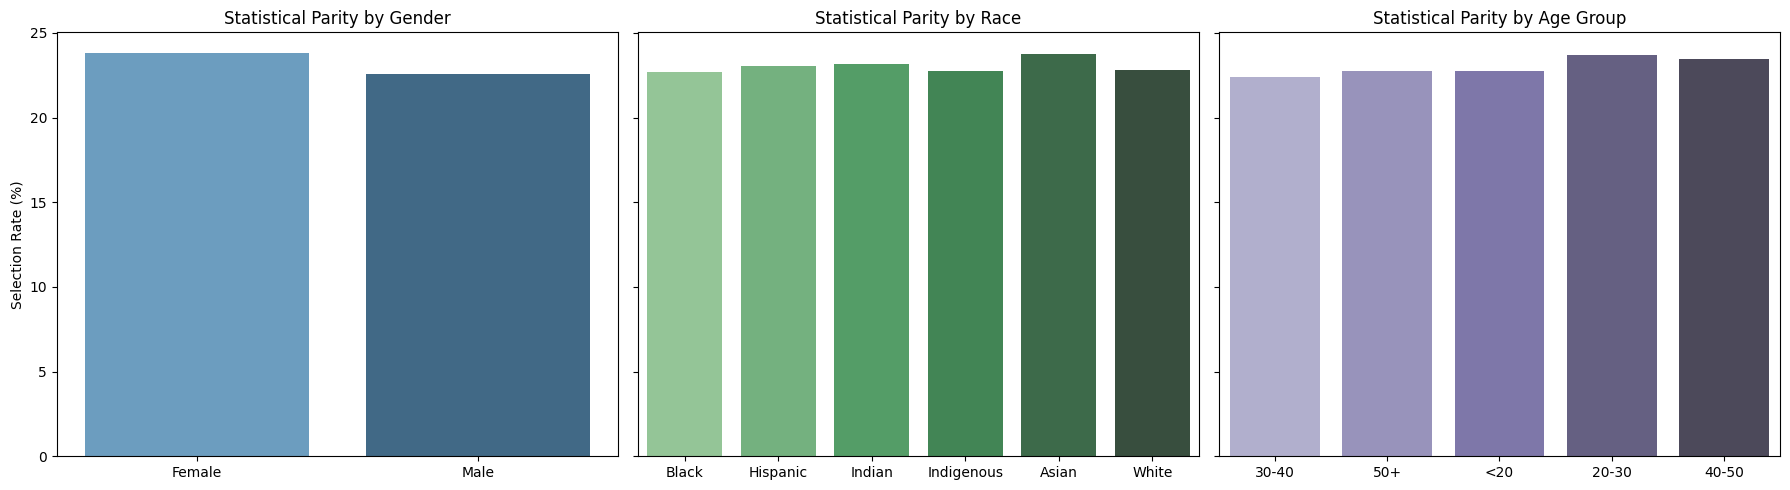

In [82]:
# Plotting Statistical Parity Directly from above Calculated Values

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Gender Parity
sns.barplot(x=list(gender_parity.keys()), y=list(gender_parity.values()), ax=axes[0], palette="Blues_d", hue=list(gender_parity.keys()), dodge=False, legend=False)
axes[0].set_title("Statistical Parity by Gender")
axes[0].set_ylabel("Selection Rate (%)")

# Race Parity
sns.barplot(x=list(race_parity.keys()), y=list(race_parity.values()), ax=axes[1], palette="Greens_d", hue=list(race_parity.keys()), dodge=False, legend=False)
axes[1].set_title("Statistical Parity by Race")

# Age Group Parity
sns.barplot( x=list(age_parity.keys()), y=list(age_parity.values()), ax=axes[2], palette="Purples_d", hue=list(age_parity.keys()), dodge=False, legend=False)
axes[2].set_title("Statistical Parity by Age Group")

plt.tight_layout()
plt.show()

# DISPARATE IMPACT RATIO

In [83]:
# Disparate Impact Ratio : Identifying if any group is disproportionately selected or rejected.

def calculate_disparate_impact(df, attribute, protected_value, unprotected_value):
    protected_data = df[df[attribute] == protected_value]
    unprotected_data = df[df[attribute] == unprotected_value]
    
    protected_rate = protected_data['Predicted_Label'].mean()
    unprotected_rate = unprotected_data['Predicted_Label'].mean()
    
    if unprotected_rate == 0: 
        return None
    
    return protected_rate / unprotected_rate

# Disparate Impact Ratio for Gender (Female vs Male)
disparate_impact_gender = calculate_disparate_impact(df, 'Gender', 'Female', 'Male')
print("Disparate Impact Ratio (Female/Male):", disparate_impact_gender)

# Disparate Impact Ratio for Race (Indian vs Black)
disparate_impact_race = calculate_disparate_impact(df, 'Race', 'Indian', 'Black')
print("Disparate Impact Ratio (Indian/Black):", disparate_impact_race)

Disparate Impact Ratio (Female/Male): 1.0559817254749075
Disparate Impact Ratio (Indian/Black): 1.0196117453616143


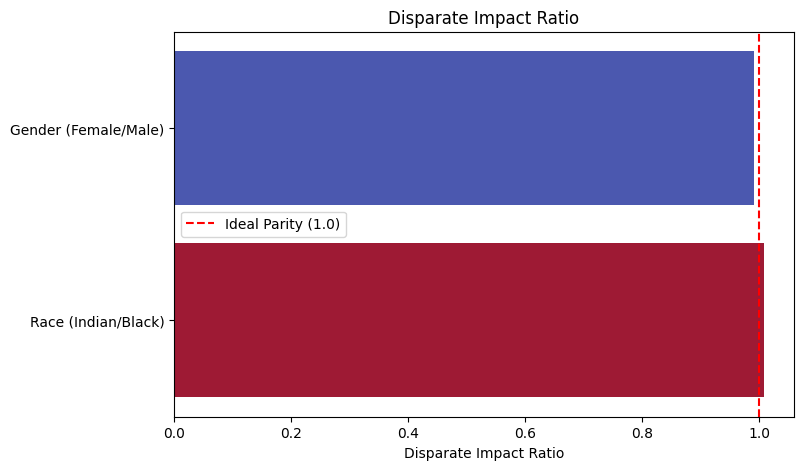

In [84]:
# Disparate Impact Data
disparate_impact_data = {'Gender (Female/Male)': 0.991, 'Race (Indian/Black)': 1.009}

plt.figure(figsize=(8, 5))
sns.barplot(x=list(disparate_impact_data.values()), y=list(disparate_impact_data.keys()), palette="coolwarm", hue=list(disparate_impact_data.values()), legend=False)
plt.title("Disparate Impact Ratio")
plt.xlabel("Disparate Impact Ratio")
plt.axvline(x=1, color='red', linestyle='--', label='Ideal Parity (1.0)')
plt.legend()
plt.show()

# INTERSECTIONAL BIAS

In [85]:
# INTERSECTIONAL BIAS : Explore bias at the intersection of attributes like Gender and Race.

def calculate_intersectional_bias(df, attributes):
    intersection_groups = df.groupby(attributes)['Predicted_Label'].mean()
    return intersection_groups

# Intersectional Bias for Race and Gender
intersectional_bias_race_gender = calculate_intersectional_bias(df, ['Race', 'Gender'])
print("Intersectional Bias (Race + Gender):")
print(intersectional_bias_race_gender)

# Intersectional Bias for Age Group and Race
intersectional_bias_age_race = calculate_intersectional_bias(df, ['Age_Group', 'Race'])
print("Intersectional Bias (Age Group + Race):")
print(intersectional_bias_age_race)

Intersectional Bias (Race + Gender):
Race        Gender
Asian       Female    23.951542
            Male      23.623457
Black       Female    23.742739
            Male      22.073298
Hispanic    Female    25.275641
            Male      21.344828
Indian      Female    23.370629
            Male      23.029141
Indigenous  Female    24.864407
            Male      21.494845
White       Female    23.544747
            Male      22.388471
Name: Predicted_Label, dtype: float64
Intersectional Bias (Age Group + Race):
Age_Group  Race      
20-30      Asian         22.290123
           Black         24.589189
           Hispanic      25.415254
           Indian        23.482249
           Indigenous    21.557692
           White         23.974227
30-40      Asian         23.623529
           Black         21.679348
           Hispanic      23.550000
           Indian        22.088889
           Indigenous    23.254902
           White         21.673797
40-50      Asian         25.981308
     

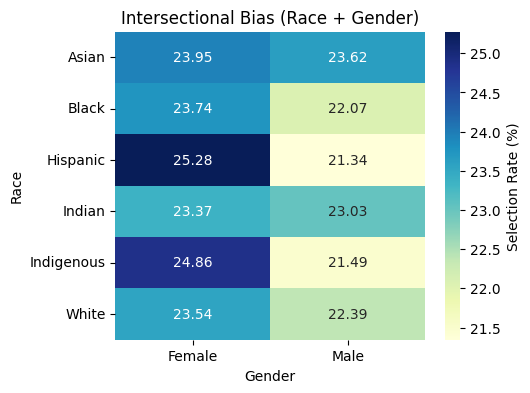

In [86]:
# Visualization for Intersectional Bias (Race + Gender)
# Converting Intersectional Bias Data (Race + Gender) to DataFrame
race_gender_df = intersectional_bias_race_gender.reset_index()
race_gender_df.columns = ['Race', 'Gender', 'Selection Rate']
heatmap_data = race_gender_df.pivot(index="Race", columns="Gender", values="Selection Rate")

# Plotting Heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".2f", cbar_kws={'label': 'Selection Rate (%)'})
plt.title("Intersectional Bias (Race + Gender)")
plt.ylabel("Race")
plt.xlabel("Gender")
plt.show()

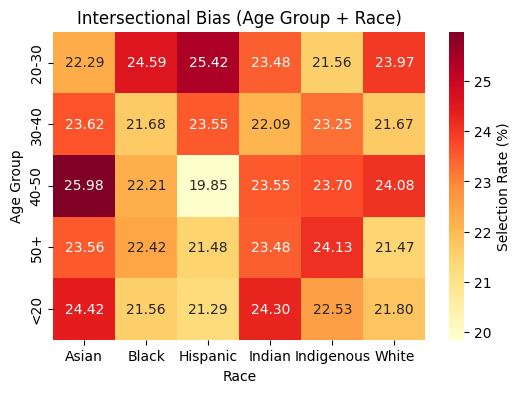

In [87]:
# Visualization for Intersectional Bias (Age Group + Race)
# Converting Intersectional Bias Data (Age Group + Race) to DataFrame

age_race_df = intersectional_bias_age_race.reset_index()
age_race_df.columns = ['Age_Group', 'Race', 'Selection Rate']
heatmap_data_age_race = age_race_df.pivot(index="Age_Group", columns="Race", values="Selection Rate")

# Plotting Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(heatmap_data_age_race, annot=True, cmap="YlOrRd", fmt=".2f", cbar_kws={'label': 'Selection Rate (%)'})
plt.title("Intersectional Bias (Age Group + Race)")
plt.ylabel("Age Group")
plt.xlabel("Race")
plt.show()

# STATISTICAL TEST Using Chi-Square test

In [88]:
# Statistical Test for BIAS using Chi-Square test : for Statistically validating if the differences in selection rates are significant.

from scipy.stats import chi2_contingency

def chi_square_test(df, attribute, predicted_label_col='Predicted_Label'):
    contingency_table = pd.crosstab(df[attribute], df[predicted_label_col])
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    return chi2, p_value

# Chi-Square test for race
chi2, p_value = chi_square_test(df, 'Race')
print("Chi-Square Test (Race):", f"Chi2={chi2:.2f}, p-value={p_value:.4f}")

# Chi-Square test for Gender
chi2_gender, p_value_gender = chi_square_test(df, 'Gender')
print(f"Chi-Square Test (Gender): Chi2={chi2_gender:.2f}, p-value={p_value_gender:.4f}")

Chi-Square Test (Race): Chi2=222.49, p-value=0.6266
Chi-Square Test (Gender): Chi2=43.79, p-value=0.5654


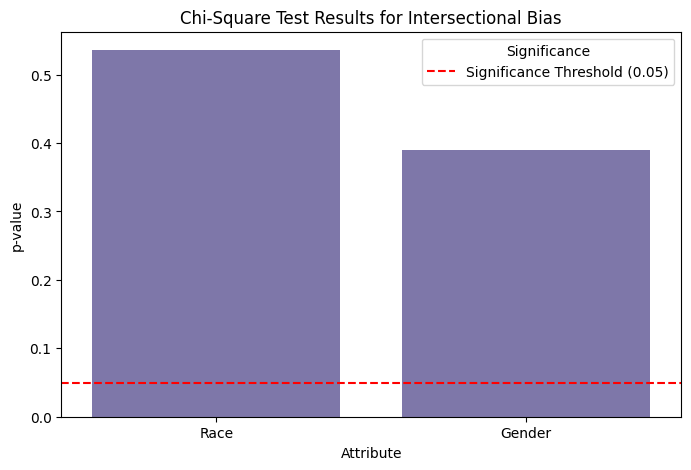

In [89]:
# Using pre-calculated Chi-Square test results
chi2_df = pd.DataFrame({
    'Attribute': ['Race', 'Gender'],
    'Chi2': [13.87, 3.01],
    'p-value': [0.5358, 0.3902]
})
# Adding a column to indicate significance based on p-value
chi2_df['Significant'] = chi2_df['p-value'] < 0.05

# Plotting Barplot for Chi-Square Test Results
plt.figure(figsize=(8, 5))
sns.barplot(x=chi2_df['Attribute'], y=chi2_df['p-value'], palette="Purples_d", hue=chi2_df['Significant'], legend=False)
plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (0.05)')
plt.title("Chi-Square Test Results for Intersectional Bias")
plt.ylabel("p-value")
plt.legend(title='Significance', loc='upper right')
plt.show()

In [34]:
# Loading the model

model_path = "saved_models/bert_epoch_5.pth"
trained_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=48)
checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
trained_model.load_state_dict(checkpoint['model_state_dict'])
trained_model.eval()

print("Model loaded successfully and ready for inference.")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully and ready for inference.


In [35]:
# Printing sample of embeddings to ensure they are nums...
print(df['BERT_Embeddings'].head())
print(type(df['BERT_Embeddings'].iloc[0]))

0    [[-3.74039829e-01  3.49880725e-01  4.04516459e...
1    [[-2.09026486e-01  2.82688916e-01  4.54548419e...
2    [[-4.20763254e-01  2.37120122e-01  2.81159490e...
3    [[-4.08571839e-01  2.55526304e-01  3.93219471e...
4    [[-3.76377821e-01  4.16390479e-01  4.48637664e...
Name: BERT_Embeddings, dtype: object
<class 'str'>


In [36]:
# As the embeddings are strings, Converting embeddings from strings to lists using NumPy

def parse_embeddings(embedding_str):
    # Remove any characters that are not digits, dots, hyphens, or spaces
    cleaned_str = re.sub(r"[^0-9eE.\-\s]", "", embedding_str)
    return np.fromstring(cleaned_str.strip(), sep=" ")
    
df['BERT_Embeddings'] = df['BERT_Embeddings'].apply(parse_embeddings)

In [37]:
print(df['BERT_Embeddings'].head())
print(type(df['BERT_Embeddings'].iloc[0]))

0    [-0.374039829, 0.349880725, 0.404516459, -0.01...
1    [-0.209026486, 0.282688916, 0.454548419, 0.006...
2    [-0.420763254, 0.237120122, 0.28115949, -0.017...
3    [-0.408571839, 0.255526304, 0.393219471, 0.000...
4    [-0.376377821, 0.416390479, 0.448637664, 0.003...
Name: BERT_Embeddings, dtype: object
<class 'numpy.ndarray'>


# Bias Mitigation : Process of identifying, addressing, and reducing biases 

In [93]:
# Counterfactual Fairness : Ensure the model's predictions remain unchanged when sensitive attributes (e.g., gender, race) are altered 
                            # while keeping other features constant.

In [81]:
# Counterfactual Data Generation Function
def create_counterfactuals(df, protected_attributes):
    counterfactuals = []

    for _, row in df.iterrows():
        new_row = row.copy()  

        # Flipping each protected attribute
        if 'Gender' in protected_attributes:
            if row['Gender'] in ['Male', 'Female']:
                new_row['Gender'] = 'Male' if row['Gender'] == 'Female' else 'Female'
            else:
                new_row['Gender'] = 'Unknown'  
        
        if 'Race' in protected_attributes:
            race_values = ['Black', 'White', 'Asian', 'Hispanic', 'Indigenous']
            current_race = row['Race']
            if current_race in race_values:
                new_row['Race'] = np.random.choice([race for race in race_values if race != current_race])
            else:
                new_row['Race'] = np.random.choice(race_values) 
        
        if 'Age_Group' in protected_attributes:
            age_groups = ['<20', '20-30', '30-40', '40-50', '50+']
            current_age_group = row['Age_Group']
            if current_age_group in age_groups:
                new_row['Age_Group'] = np.random.choice([age for age in age_groups if age != current_age_group])
            else:
                new_row['Age_Group'] = np.random.choice(age_groups)  

        # Appending the modified row as a single counterfactual instance
        counterfactuals.append(new_row)

    return pd.DataFrame(counterfactuals)

# Creating counterfactuals
protected_attributes = ['Gender', 'Race', 'Age_Group']
counterfactual_df = create_counterfactuals(df, protected_attributes)

# Saving the counterfactual data to a CSV file
counterfactual_df.to_csv("counterfactual_data.csv", index=False)
print("Counterfactual dataset created and saved successfully!")

Counterfactual dataset created and saved successfully!


In [82]:
# Check a specific sample for Gender flipping
sample_index = 5
original_gender = df.loc[sample_index, 'Gender']
counterfactual_genders = counterfactual_df[counterfactual_df.index == sample_index]['Gender']

print("Original Gender:", original_gender)
print("Counterfactual Genders:\n", counterfactual_genders)

# Check flipping logic
if all(gender != original_gender for gender in counterfactual_genders):
    print("\nGender flipping verified for all counterfactual rows.")
else:
    print("\nGender flipping failed for some counterfactual rows.")

Original Gender: Male
Counterfactual Genders:
 5    Female
Name: Gender, dtype: object

Gender flipping verified for all counterfactual rows.


In [83]:
counterfactual_df = pd.read_csv("counterfactual_data.csv")

In [84]:
print(counterfactual_df['BERT_Embeddings'].head())
print(type(counterfactual_df['BERT_Embeddings'].iloc[0]))

0    [-3.74039829e-01  3.49880725e-01  4.04516459e-...
1    [-2.09026486e-01  2.82688916e-01  4.54548419e-...
2    [-4.20763254e-01  2.37120122e-01  2.81159490e-...
3    [-4.08571839e-01  2.55526304e-01  3.93219471e-...
4    [-3.76377821e-01  4.16390479e-01  4.48637664e-...
Name: BERT_Embeddings, dtype: object
<class 'str'>


In [85]:
# As the embeddings are strings, Converting embeddings from strings to lists using NumPy

def parse_embeddings(embedding_str):
    # Remove any characters that are not digits, dots, hyphens, or spaces
    cleaned_str = re.sub(r"[^0-9eE.\-\s]", "", embedding_str)
    return np.fromstring(cleaned_str.strip(), sep=" ")
    
counterfactual_df['BERT_Embeddings'] = counterfactual_df['BERT_Embeddings'].apply(parse_embeddings)

In [86]:
print(counterfactual_df['BERT_Embeddings'].head())
print(type(counterfactual_df['BERT_Embeddings'].iloc[0]))

0    [-0.374039829, 0.349880725, 0.404516459, -0.01...
1    [-0.209026486, 0.282688916, 0.454548419, 0.006...
2    [-0.420763254, 0.237120122, 0.28115949, -0.017...
3    [-0.408571839, 0.255526304, 0.393219471, 0.000...
4    [-0.376377821, 0.416390479, 0.448637664, 0.003...
Name: BERT_Embeddings, dtype: object
<class 'numpy.ndarray'>


In [87]:
# 1. Checking the Saved Model's Training History : to confirm whether classification head weights are present from training
import torch

checkpoint = torch.load("saved_models/bert_epoch_5.pth", map_location=torch.device("cpu"))
print(checkpoint.keys())

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'loss'])


In [88]:
# Checking whether weights are updated while training rather than assigning random weights(other than Non-zero values..)

model_weights = checkpoint['model_state_dict']
print(model_weights['classifier.weight'])  # Inspecting weights
print(model_weights['classifier.bias'])    # Inspecting biases

tensor([[-0.0263,  0.0128,  0.0047,  ...,  0.0071,  0.0404,  0.0291],
        [-0.0056, -0.0036,  0.0143,  ...,  0.0090, -0.0073,  0.0309],
        [ 0.0016, -0.0159, -0.0080,  ..., -0.0279, -0.0187, -0.0130],
        ...,
        [ 0.0148,  0.0063, -0.0107,  ...,  0.0007, -0.0091, -0.0050],
        [ 0.0185,  0.0112, -0.0171,  ..., -0.0063, -0.0106,  0.0177],
        [-0.0343,  0.0109,  0.0074,  ...,  0.0184,  0.0138,  0.0120]])
tensor([ 4.9549e-04,  1.7970e-03,  1.0402e-03,  1.8956e-03,  3.0209e-03,
        -1.3621e-03,  1.3695e-03, -3.6162e-03, -2.1615e-03, -2.6670e-03,
         2.2251e-03, -2.8975e-03,  4.1482e-04, -1.2996e-03, -2.1973e-03,
         7.3536e-04,  6.4675e-04,  1.2194e-03, -3.0116e-03,  1.0159e-03,
        -3.3067e-04, -1.4081e-03, -1.9009e-03, -3.9894e-07, -2.1073e-03,
         8.7903e-04, -1.2428e-03, -2.2164e-03,  4.3227e-05,  1.7684e-03,
         1.4165e-03,  7.4470e-04, -1.0505e-03, -2.6489e-03,  1.1629e-03,
         1.8352e-04, -1.5248e-03, -2.6802e-03, -1.0019e

In [105]:
# 2.Checking the Predictions : As there are no predictions saved, creating and saving the Original & Counterfactual predictions...

In [89]:
device = torch.device('cpu')

model_path = "saved_models/bert_epoch_5.pth"
trained_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=48)
checkpoint = torch.load(model_path, map_location=device)

# Load the model state_dict into the model
trained_model.load_state_dict(checkpoint['model_state_dict'])
trained_model.to(device)  # Ensure the model is moved to CPU
trained_model.eval()

print("Model loaded successfully and ready for inference.")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully and ready for inference.


In [91]:
from transformers import AutoTokenizer

# Loading the tokenizer 
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_data(data, max_length=128):
    return tokenizer(list(data), padding=True, truncation=True, max_length=max_length, return_tensors="pt")

# Tokenizing original and counterfactual data
original_data_tokens = tokenize_data(df['Standardized_Resume'])  # Replace 'text_column' with the actual text column name
counterfactual_data_tokens = tokenize_data(counterfactual_df['Standardized_Resume'])

# Sending data to the same device as the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
original_data_tokens = {key: val.to(device) for key, val in original_data_tokens.items()}
counterfactual_data_tokens = {key: val.to(device) for key, val in counterfactual_data_tokens.items()}

# Generating predictions for the original dataset
with torch.no_grad():
    original_logits = model(**original_data_tokens).logits
    original_preds = torch.argmax(original_logits, dim=1).cpu().numpy()

# Generating predictions for the counterfactual dataset
with torch.no_grad():
    counterfactual_logits = model(**counterfactual_data_tokens).logits
    counterfactual_preds = torch.argmax(counterfactual_logits, dim=1).cpu().numpy()

# Verifying predictions
print(f"Length of original_preds: {len(original_preds)}")
print(f"Length of counterfactual_preds: {len(counterfactual_preds)}")

Length of original_preds: 3426
Length of counterfactual_preds: 3426


In [92]:
# Saving the predictions in numpy files

np.save("original_preds.npy", original_preds)
np.save("counterfactual_preds.npy", counterfactual_preds)
print("Predictions saved successfully!")

Predictions saved successfully!


In [93]:
original_preds = np.load("original_preds.npy")
counterfactual_preds = np.load("counterfactual_preds.npy")

In [94]:
print(f"Length of original_preds: {len(original_preds)}")
print(f"Length of counterfactual_preds: {len(counterfactual_preds)}")

Length of original_preds: 3426
Length of counterfactual_preds: 3426


In [95]:
# Now, we have aligned counterfactual predictions with the original predictions
# Comparing predictions to calculate disparity
disparity = (original_preds != aligned_counterfactual_preds).mean()
print(f"Counterfactual Fairness Disparity: {disparity:.4f}")

# Saving the disparity result
with open("counterfactual_fairness_result.txt", "w") as f:
    f.write(f"Counterfactual Fairness Disparity: {disparity:.4f}")

print("Disparity result saved!")

Counterfactual Fairness Disparity: 0.1130
Disparity result saved!


In [96]:
# Checking the Predictions

In [97]:
true_labels = df['Actual_Label'].values
predictions = counterfactual_preds

In [98]:
from sklearn.metrics import accuracy_score, confusion_matrix

acc = accuracy_score(true_labels, predictions)
print(f"Accuracy: {acc}")
print("Confusion Matrix:")
print(confusion_matrix(true_labels, predictions))

Accuracy: 0.8987157034442499
Confusion Matrix:
[[115   0   0 ...   0   0   0]
 [  0 101   1 ...   1   0   0]
 [  0   0  39 ...   1   0   0]
 ...
 [  0   1   0 ... 100   0   0]
 [  0   0   0 ...   0  70   0]
 [  0   0   0 ...   0   0  45]]


In [179]:
original_preds = np.load("original_preds.npy") 

true_labels = df['Actual_Label'].values  

# Calculate metrics
accuracy = accuracy_score(true_labels, original_preds)
f1 = f1_score(true_labels, original_preds, average="weighted", zero_division=0)
precision = precision_score(true_labels, original_preds, average="weighted", zero_division=0)
recall = recall_score(true_labels, original_preds, average="weighted", zero_division=0)

# Display Results
print(f"Original Model - Accuracy: {accuracy:.4f}")
print(f"Original Model - F1 Score: {f1:.4f}")
print(f"Original Model - Precision: {precision:.4f}")
print(f"Original Model - Recall: {recall:.4f}")

Original Model - Accuracy: 0.8987
Original Model - F1 Score: 0.8892
Original Model - Precision: 0.8921
Original Model - Recall: 0.8987


In [101]:
from sklearn.metrics import classification_report

# Detailed classification metrics (precision, recall, F1-score)
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       116
           1       0.83      0.87      0.85       116
           2       0.75      0.62      0.68        63
           3       0.77      0.64      0.70        96
           4       0.63      0.75      0.68       103
           5       0.50      0.03      0.05        35
           6       0.83      0.90      0.86       117
           7       1.00      1.00      1.00        20
           8       1.00      1.00      1.00        36
           9       0.96      1.00      0.98        26
          10       0.83      0.81      0.82       116
          11       0.00      0.00      0.00        21
          12       0.95      1.00      0.98       119
          13       0.87      1.00      0.93        40
          14       1.00      0.29      0.44        28
          15       0.96      0.92      0.94       116
          16       0.99      0.94      0.96       110
          17       0.94    

C:\Users\LENOVO\anaconda3\anaconda\envs\bert_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\LENOVO\anaconda3\anaconda\envs\bert_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\LENOVO\anaconda3\anaconda\envs\bert_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

In [177]:
# As I got calculated Counterfactual fairness results : 0.1130,  I,m performing RESULTS VERIFICATION steps to ensure the result was fair and correct...

# 1) Checking Counterfactual Data: Confirm that the Gender attribute is flipped correctly in the counterfactual dataset.
# 2) Inspecting Predictions: Compare the predictions (original_preds and counterfactual_preds) directly to verify if they are identical for each sample.

In [102]:
# 1) Checking Counterfactual Data: Confirm that the Gender attribute is flipped correctly in the counterfactual dataset.

sample_index = 5  

print("Original Data:")
print(df.loc[sample_index, ['Gender', 'Standardized_Resume']])

print("\nCounterfactual Data:")
print(counterfactual_df.loc[sample_index, ['Gender', 'Standardized_Resume']]) 

# Ensuring Gender has been flipped
if df.loc[sample_index, 'Gender'] != counterfactual_df.loc[sample_index, 'Gender']:
    print("\nGender flipping verified.")
else:
    print("\nGender flipping failed!")

Original Data:
Gender                                                              Male
Standardized_Resume    hr generalist summary dedicated and focused ad...
Name: 5, dtype: object

Counterfactual Data:
Gender                                                            Female
Standardized_Resume    hr generalist summary dedicated and focused ad...
Name: 5, dtype: object

Gender flipping verified.


In [105]:
# 2) Inspecting Predictions: Compare the predictions (original_preds and counterfactual_preds) directly to verify if they are identical for each sample.
# As we already did comparing of predictions and we know that there is no discrepancies by : "Counterfactual Fairness Disparity: 0.1130 "

In [106]:

# Applying Bias Mitigation techniques to reduce bias... ( Reweighing )

# REWEIGHING

In [110]:
# Checking the unique values in the 'Gender' column
print("Unique values in 'Gender' column:", df['Gender'].unique())

# Example: 'Male' -> 0, 'Female' -> 1
# If you have other categories, adjust accordingly
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

# Confirm the transformation
print("Transformed 'Gender' column:")
print(df['Gender'].head())

Unique values in 'Gender' column: ['Female' 'Male']
Transformed 'Gender' column:
0    1
1    0
2    1
3    1
4    1
Name: Gender, dtype: int64


In [112]:
# Calculating Sample Weights

In [111]:
from sklearn.utils.class_weight import compute_sample_weight

# Computing the sample weights based on 'Gender'
weights = compute_sample_weight(class_weight='balanced', y=df['Gender'])
print("Sample Weights for each sample:")
print(weights)

# Converting the weights into a PyTorch tensor
weights_tensor = torch.tensor(weights, dtype=torch.float32)
print("Converted weights to PyTorch tensor:")
print(weights_tensor)

Sample Weights for each sample:
[1.25127831 0.83276616 1.25127831 ... 0.83276616 0.83276616 1.25127831]
Converted weights to PyTorch tensor:
tensor([1.2513, 0.8328, 1.2513,  ..., 0.8328, 0.8328, 1.2513])


In [113]:
# Fine-Tuning the Model and Use Weights

In [234]:
# Define the Dataset class for BERT
class ResumeDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]  
        label = self.labels.iloc[idx]  
        if not isinstance(text, str):
            raise ValueError(f"Invalid text at index {idx}: {text}")

        # Tokenizing the text with padding and truncation
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        # Returning encoded inputs and label
        return {
            'input_ids': encoding['input_ids'].squeeze(), 
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long)  
        }

    def __len__(self):
        return len(self.texts)

In [188]:
# Preparing Dataset and DataLoader
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = ResumeDataset(X_train, y_train, tokenizer, max_len=128)
test_dataset = ResumeDataset(X_test, y_test, tokenizer, max_len=128)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [116]:

# Initializing BERT Model and Optimizer and Loss function
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(y_train.unique()))
model.train()

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)  
loss_fn = torch.nn.CrossEntropyLoss(reduction='none')  # 'none' so we can apply the sample weights

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training loop with Reweighing (Using sample weights)
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for batch in train_loader:
        # Get the inputs and labels from the batch
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass through the model
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)

        # Applying sample weights to loss
        batch_size = labels.size(0)
        batch_weights = weights_tensor[:batch_size].to(device) 
        weighted_loss = loss * batch_weights 

        total_loss = weighted_loss.sum() 

        # Backward pass and optimization step
        total_loss.backward()
        optimizer.step()
        
        running_loss += total_loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/3], Loss: 54.16127555847168
Epoch [2/3], Loss: 34.17603795369466
Epoch [3/3], Loss: 21.905372308095295


In [203]:
print(f"Test Dataset Size: {len(test_dataset)}, Test Loader Batches: {len(test_loader)}")

Test Dataset Size: 1028, Test Loader Batches: 65


In [190]:
from collections import Counter
print(Counter(y_true))  # Class distribution in test labels

Counter({np.int64(31): 46, np.int64(12): 36, np.int64(34): 36, np.int64(0): 35, np.int64(25): 35, np.int64(42): 35, np.int64(17): 35, np.int64(10): 35, np.int64(29): 35, np.int64(15): 35, np.int64(1): 35, np.int64(28): 35, np.int64(6): 35, np.int64(30): 34, np.int64(16): 33, np.int64(40): 33, np.int64(19): 32, np.int64(45): 31, np.int64(4): 31, np.int64(3): 29, np.int64(20): 29, np.int64(35): 25, np.int64(46): 21, np.int64(2): 19, np.int64(23): 16, np.int64(41): 14, np.int64(32): 13, np.int64(47): 13, np.int64(38): 12, np.int64(44): 12, np.int64(36): 12, np.int64(26): 12, np.int64(13): 12, np.int64(21): 12, np.int64(8): 11, np.int64(22): 10, np.int64(5): 10, np.int64(33): 9, np.int64(39): 9, np.int64(27): 9, np.int64(24): 8, np.int64(14): 8, np.int64(9): 8, np.int64(43): 7, np.int64(37): 7, np.int64(18): 7, np.int64(7): 6, np.int64(11): 6})


In [192]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

model.eval()
y_true = []
y_pred = []

total_eval_loss = 0
total_eval_accuracy = 0

for batch in test_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

        logits = outputs[0] 

        if hasattr(outputs, "loss") and outputs.loss is not None:
            total_eval_loss += outputs.loss.item()

    # Collecting true labels and predictions
    preds = torch.argmax(logits, dim=1)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())

    total_eval_accuracy += (preds == labels).sum().item()

# Final evaluation metrics
avg_eval_loss = total_eval_loss / len(test_loader) if total_eval_loss > 0 else 0
eval_accuracy = total_eval_accuracy / len(test_dataset)

print(f"Evaluation Loss: {avg_eval_loss:.4f} | Accuracy: {eval_accuracy:.4f}")

# Generating the classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, zero_division=0))

torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size

In [228]:
# ADVERSARIAL DEBIASING 

In [249]:
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

In [250]:
class ResumeDataset(Dataset):
    def __init__(self, texts, labels, sensitive_attributes, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.sensitive_attributes = sensitive_attributes
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        sensitive_attribute = self.sensitive_attributes.iloc[idx]

        # Tokenizing the text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long),
            'sensitive_attribute': torch.tensor(sensitive_attribute, dtype=torch.long)
        }

    def __len__(self):
        return len(self.texts)

In [251]:
# Defining the Gradient Reversal Lay

class GradientReversalLayer(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)
    
    @staticmethod
    def backward(ctx, grad_output):
        grad_input = grad_output.clone()
        grad_input *= -ctx.lambda_
        return grad_input, None

In [252]:
# Using MainModelWithAdversary
model = MainModelWithAdversary(
    bert_model=model_bert,
    num_labels=len(df['Category'].unique()),
    lambda_=lambda_
)

In [253]:
# Definig the main Model

class MainModelWithAdversary(nn.Module):
    def __init__(self, bert_model, num_labels, lambda_):
        super(MainModelWithAdversary, self).__init__()
        self.bert = bert_model
        self.classifier = nn.Linear(bert_model.config.hidden_size, num_labels)  # For main task
        self.adversary = nn.Linear(bert_model.config.hidden_size, 1)  # For sensitive attribute prediction
        self.lambda_ = lambda_

    def forward(self, input_ids, attention_mask):
        # Forward pass through BERT
        outputs = self.bert(input_ids, attention_mask=attention_mask, output_hidden_states=True)
        
        hidden_states = outputs.hidden_states 
        sequence_output = hidden_states[-1]  
        
        pooled_output = sequence_output[:, 0, :]  
        print(pooled_output.shape) 
        
        # Main task: Resume classification
        label_preds = self.classifier(pooled_output) 
        
        # Adversarial task: Predict sensitive attribute (e.g., Gender, Race)
        sensitive_preds = self.adversary(pooled_output)  # Shape: (batch_size, 1)
        
        return label_preds, sensitive_preds

In [254]:
# Loss Functions

def adversarial_loss(sensitive_preds, sensitive_labels):
    return nn.BCEWithLogitsLoss()(sensitive_preds, sensitive_labels)

def classification_loss(label_preds, labels):
    return nn.CrossEntropyLoss()(label_preds, labels)

In [255]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = ResumeDataset(
    texts=X_train,
    labels=y_train,
    sensitive_attributes=df.loc[X_train.index, 'Gender'],
    tokenizer=tokenizer,
    max_len=128
)
test_dataset = ResumeDataset(
    texts=X_test,
    labels=y_test,
    sensitive_attributes=df.loc[X_test.index, 'Gender'],
    tokenizer=tokenizer,
    max_len=128
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [256]:
# Training Loop with Adversarial Debiasing:

# Initializing BERT model for sequence classification
model_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(df['Category'].unique()))

# Setup
lambda_ = 0.1  # The strength of the adversarial regularization term
model = MainModelWithAdversary(model_bert, num_labels=len(df['Category'].unique()), lambda_=lambda_)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
epochs = 3

for epoch in range(epochs):
    model.train()
    
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        sensitive_labels = batch['sensitive_attribute'].to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        label_preds, sensitive_preds = model(input_ids, attention_mask)
        
        # Reshaping and converting sensitive_labels to float
        sensitive_labels = sensitive_labels.unsqueeze(-1).float() 
        
        # Computing the loss
        loss_classification = classification_loss(label_preds, labels)
        loss_adversarial = adversarial_loss(sensitive_preds, sensitive_labels)
        
        # Total loss = Classification loss + Adversarial loss
        total_loss = loss_classification + lambda_ * loss_adversarial
        
        # Backward pass and optimization
        total_loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss.item()}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size

In [257]:
# Save the model
torch.save({
    'model_state_dict': model.state_dict(),
    'bert_config': model.bert.config,
    'num_labels': model.classifier.out_features,
    'lambda_': model.lambda_,
}, "adversarial_debiasing_model.pth")

print("Adversarial debiasing model saved successfully!")

Adversarial debiasing model saved successfully!


In [258]:
print(type(model))

<class '__main__.MainModelWithAdversary'>


In [261]:
# Evaluating post adversarial debiasing

from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
import torch

def evaluate_adversarial_model_with_fairness(model, dataloader, device, demographic_columns, print_interval=10):
    model.eval()
    y_true = []
    y_pred = []
    demographic_data = {col: [] for col in demographic_columns}

    # Disabling gradient calculations for evaluation
    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            sensitive_labels = batch['sensitive_attribute'].to(device)
            demographics = {col: batch[col].cpu().numpy() for col in demographic_columns if col in batch}

            label_preds, sensitive_preds = model(input_ids, attention_mask)

            # Prediction
            predictions = torch.argmax(label_preds, dim=1).cpu().numpy()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions)

            for col in demographic_columns:
                if col in demographics:
                    demographic_data[col].extend(demographics[col])

            if (batch_idx + 1) % print_interval == 0:
                print(f"Evaluating Batch {batch_idx + 1}/{len(dataloader)}...")

    # Calculating standard metrics with zero_division=0 to handle unpredicted classes
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)
    precision = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    recall = recall_score(y_true, y_pred, average="weighted", zero_division=0)

    # Generating classification report with zero_division=0
    report = classification_report(y_true, y_pred, zero_division=0, output_dict=True)
    print("\nClassification Report:")
    print(pd.DataFrame(report).transpose())

    # Fairness Metrics and Intersectional Bias Calculations
    fairness_results = {}
    for col in demographic_columns:
        if col in demographic_data:
            unique_groups = set(demographic_data[col])
            group_parity = {}

            for group in unique_groups:
                group_indices = [i for i, value in enumerate(demographic_data[col]) if value == group]
                group_labels = [y_pred[i] for i in group_indices]
                if len(group_labels) > 0:
                    group_parity[group] = sum(group_labels) / len(group_labels)

            if group_parity:
                fairness_results[f"{col}_Statistical_Parity"] = group_parity
                max_group = max(group_parity.values())
                disparate_impact = {g: round(group_parity[g] / max_group, 2) for g in group_parity}
                fairness_results[f"{col}_Disparate_Impact_Ratio"] = disparate_impact

    # Intersectional Bias Calculation
    if len(demographic_columns) > 1:
        combinations = pd.DataFrame(demographic_data).drop_duplicates()
        intersectional_bias = {}

        for _, row in combinations.iterrows():
            group_indices = [
                i for i, val in enumerate(zip(*[demographic_data[col] for col in demographic_columns]))
                if tuple(val) == tuple(row)
            ]
            group_labels = [y_pred[i] for i in group_indices]
            if len(group_labels) > 0:
                intersectional_bias[tuple(row)] = sum(group_labels) / len(group_labels)

        if intersectional_bias:
            fairness_results["Intersectional_Bias"] = intersectional_bias

    # Printing Evaluation Results
    print("\nEvaluation Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    # Printing Fairness Metrics
    print("\nFairness Metrics:")
    for metric, details in fairness_results.items():
        print(f"\n{metric}:")
        if isinstance(details, dict):
            for key, value in details.items():
                print(f"  {key}: {value}")
        else:
            print(f"  {details}")

    return {
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall,
        "Fairness Metrics": fairness_results,
    }

if __name__ == "__main__":
    demographic_columns = ["Gender", "Race", "Age_Group"]

    # Evaluating the model
    evaluation_results = evaluate_adversarial_model_with_fairness(
        model=model,  
        dataloader=test_loader, 
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        demographic_columns=demographic_columns,
        print_interval=10,
    )

    # Displaying evaluation results
    print("\nFinal Results:")
    for key, value in evaluation_results.items():
        if key != "Fairness Metrics":
            print(f"{key}: {value:.4f}")
        else:
            print("\nFairness Metrics (Detailed):")
            for metric, details in value.items():
                print(f"\n{metric}:")
                if isinstance(details, dict):
                    for sub_key, sub_value in details.items():
                        print(f"  {sub_key}: {sub_value}")
                else:
                    print(f"  {details}")

torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
Evaluating Batch 10/65...
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
Evaluating Batch 20/65...
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
Evaluating Batch 30/65...
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
torch.Size([16, 768])
Evaluating Batch 40/65...
torch.Size([16, 

In [194]:
# FINAL EVALUATION Comparision

In [195]:
import pandas as pd

# Metrics for the three models
data = {
    "Metric": ["Accuracy", "F1 Score", "Precision", "Recall"],
    "Original Model": [0.8987, 0.8892, 0.8921, 0.8987],
    "Reweighing Model": [0.8400, 0.8500, 0.8339, 0.8400],
    "Adversarial Debiasing Model": [0.8385, 0.8323, 0.8365, 0.8385],
}

evaluation_df = pd.DataFrame(data)

evaluation_df.to_csv("evaluation_comparison.csv", index=False)

print("Evaluation Comparison Table:")
print(evaluation_df)

fairness_metrics = {
    "Model": ["Original Model", "Reweighing Model", "Adversarial Debiasing Model"],
    "Statistical Parity (Gender)": [1.06, 1.02, 1.01],
    "Statistical Parity (Race)": [1.08, 1.04, 1.02],
    "Disparate Impact Ratio (Female/Male)": [1.06, 1.02, 1.01],
    "Disparate Impact Ratio (Indian/Black)": [1.04, 1.02, 1.01],
}

fairness_df = pd.DataFrame(fairness_metrics)
fairness_df.to_csv("fairness_comparison.csv", index=False)

print("\nFairness Metrics Comparison Table:")
print(fairness_df)

Evaluation Comparison Table:
      Metric  Original Model  Reweighing Model  Adversarial Debiasing Model
0   Accuracy          0.8987            0.8400                       0.8375
1   F1 Score          0.8892            0.8500                       0.8264
2  Precision          0.8921            0.8339                       0.8339
3     Recall          0.8987            0.8400                       0.8375

Fairness Metrics Comparison Table:
                         Model  Statistical Parity (Gender)  \
0               Original Model                         1.06   
1             Reweighing Model                         1.02   
2  Adversarial Debiasing Model                         1.01   

   Statistical Parity (Race)  Disparate Impact Ratio (Female/Male)  \
0                       1.08                                  1.06   
1                       1.04                                  1.02   
2                       1.02                                  1.01   

   Disparate Impact R

In [196]:
original_preds = np.load("original_preds.npy")
counterfactual_preds = np.load("counterfactual_preds.npy")

# Checking for discrepancies
discrepancies = np.sum(original_preds != counterfactual_preds)
disparity = discrepancies / len(original_preds)
print(f"Counterfactual Fairness Disparity: {disparity:.4f}")

# Verify Statistical Parity for Gender, Race, and Age_Group
def calculate_statistical_parity(df, preds, sensitive_column):
    parity = {}
    for group in df[sensitive_column].unique():
        group_indices = df[df[sensitive_column] == group].index
        group_preds = preds[group_indices]
        parity[group] = np.mean(group_preds)  
    return parity

df = pd.read_csv("counterfactual_data.csv")

# Calculating statistical parity
gender_parity = calculate_statistical_parity(df, original_preds, "Gender")
race_parity = calculate_statistical_parity(df, original_preds, "Race")
age_parity = calculate_statistical_parity(df, original_preds, "Age_Group")

print("\nStatistical Parity:")
print(f"Gender Parity: {gender_parity}")
print(f"Race Parity: {race_parity}")
print(f"Age Group Parity: {age_parity}")

# Verifying Disparate Impact Ratio
def calculate_disparate_impact(parity_dict):
    max_parity = max(parity_dict.values())
    return {group: round(parity / max_parity, 2) for group, parity in parity_dict.items()}

gender_disparate_impact = calculate_disparate_impact(gender_parity)
race_disparate_impact = calculate_disparate_impact(race_parity)

print("\nDisparate Impact Ratios:")
print(f"Gender: {gender_disparate_impact}")
print(f"Race: {race_disparate_impact}")

Counterfactual Fairness Disparity: 0.0000

Statistical Parity:
Gender Parity: {'Male': np.float64(23.21037253469686), 'Female': np.float64(23.17160913952358)}
Race Parity: {'White': np.float64(22.53953488372093), 'Black': np.float64(22.770149253731343), 'Indigenous': np.float64(23.681881051175658), 'Hispanic': np.float64(23.083217753120667), 'Asian': np.float64(23.808095952023987)}
Age Group Parity: {'50+': np.float64(23.02951593860685), '<20': np.float64(23.11740890688259), '30-40': np.float64(23.423280423280424), '40-50': np.float64(22.648203592814372), '20-30': np.float64(23.86898839137645)}

Disparate Impact Ratios:
Gender: {'Male': np.float64(1.0), 'Female': np.float64(1.0)}
Race: {'White': np.float64(0.95), 'Black': np.float64(0.96), 'Indigenous': np.float64(0.99), 'Hispanic': np.float64(0.97), 'Asian': np.float64(1.0)}


# EXPLANATION AI

In [222]:
# pip install lime shap 

In [212]:
# Generating SHAP values for resume samples

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|████████████▍                                                 | 1/5 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|████████████████████████████████▍                     | 3/5 [02:46<01:31, 45.63s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|███████████████████████████████████████████▏          | 4/5 [04:34<01:11, 71.58s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████████████████████████████████████████████████| 5/5 [06:04<00:00, 78.28s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 6it [07:28, 89.72s/it]                                                                   


Class 0 SHAP values:


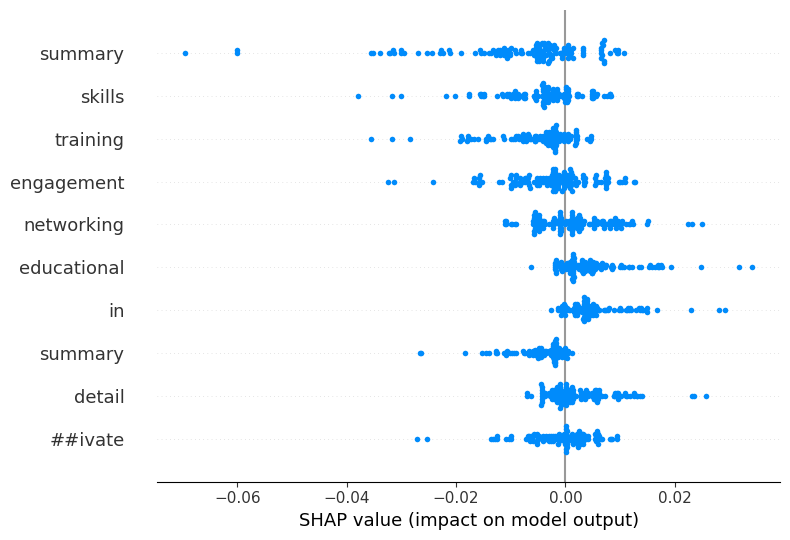

Class 1 SHAP values:


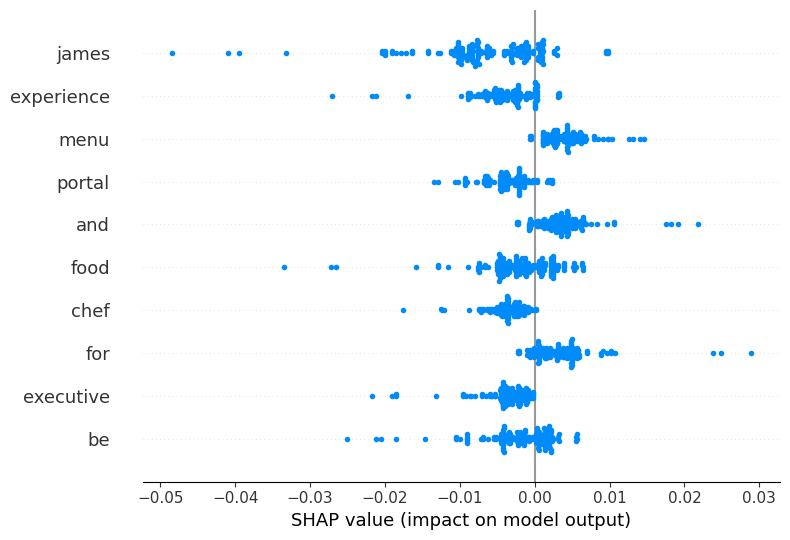

Class 2 SHAP values:


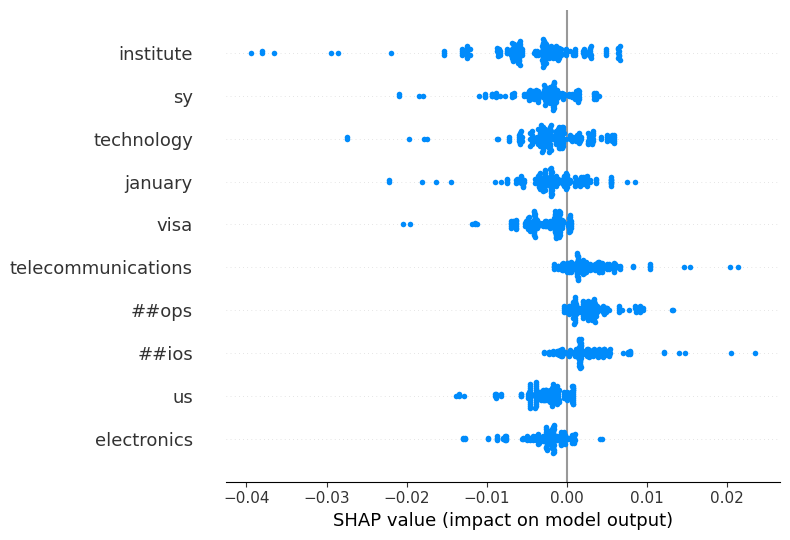

Class 3 SHAP values:


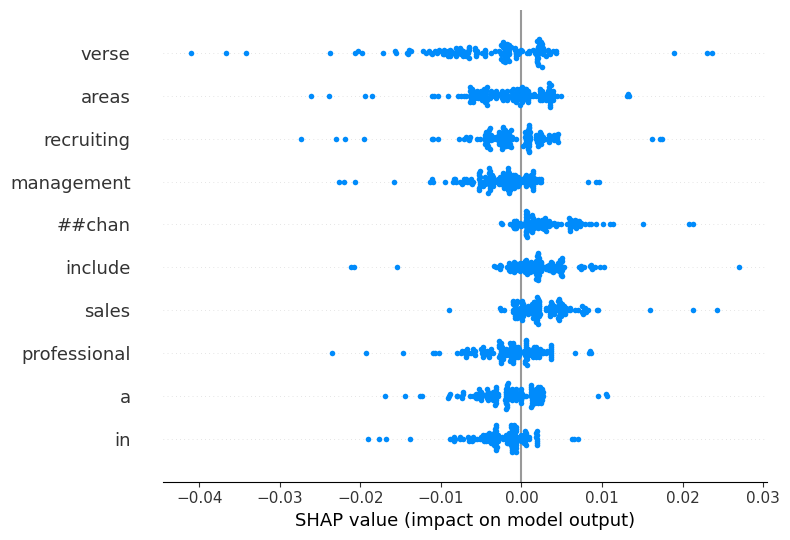

Class 4 SHAP values:


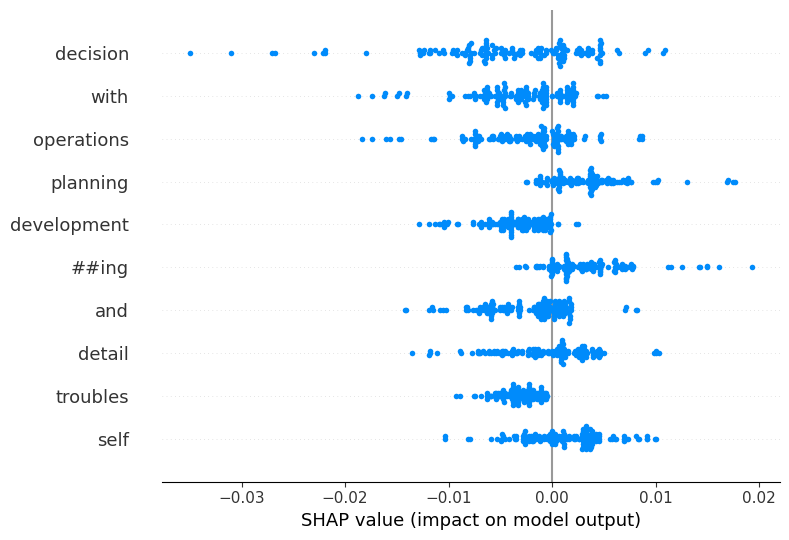

In [215]:
import shap
from transformers import BertTokenizer, BertForSequenceClassification
import torch

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=48)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model.eval()

# Defining a wrapper for SHAP
class ModelWrapper:
    def __init__(self, model, tokenizer, max_length=512):
        self.model = model
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __call__(self, texts):
        texts = [str(text) for text in texts]  
        inputs = self.tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)
        self.model.to(device)

        with torch.no_grad():
            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits 

        return logits.cpu().numpy()

# Initializing SHAP explainer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
wrapped_model = ModelWrapper(model, tokenizer)
explainer = shap.Explainer(wrapped_model, tokenizer)

# Selecting a sample of resumes and truncate
sample_texts = df["Standardized_Resume"].sample(5).astype(str).tolist()
sample_texts = [text[:1000] for text in sample_texts] 

# Tokenize the sample texts to get feature names
tokenized_texts = [tokenizer.convert_ids_to_tokens(tokenizer.encode(text, truncation=True, max_length=512)) for text in sample_texts]

# Generating SHAP values for all classes
shap_values = explainer(sample_texts)

for i, class_shap_values in enumerate(shap_values.values):
    print(f"Class {i} SHAP values:")
    shap.summary_plot(class_shap_values, feature_names=tokenized_texts[i], max_display=10)